In [1]:
import numpy as np
import jaxeffort
import jax
import matplotlib.pyplot as plt
import json

Initializing neutrino interpolants with dual-grid strategy...
Creating F_interpolant grid...
Creating dFdy_interpolant grid...
F grid: 1100 points from 0.001000 to 1000.0
dFdy grid: 20000 points from 0.001000 to 1000.0
Computing F values...
Computing dFdy values...
Creating Akima interpolators...
Dual-grid interpolants initialized successfully!
jaxeffort: Initializing multipole emulators...
  Loading pybird_mnuw0wacdm...
  pybird_mnuw0wacdm: Loaded 3/3 multipoles (l=['0', '2', '4'])


In [2]:
P0 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["0"]
P2 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["2"]
P4 = jaxeffort.trained_emulators["pybird_mnuw0wacdm"]["4"]

In [3]:
P0.P11.in_MinMax

Array([[ 2.85006729e-01,  1.89999327e+00],
       [ 2.00000625e+00,  3.49999375e+00],
       [ 8.00001250e-01,  1.09999875e+00],
       [ 5.00001667e+01,  8.99998333e+01],
       [ 2.00000208e-02,  2.49999792e-02],
       [ 9.00003750e-02,  1.79999625e-01],
       [ 2.08333333e-06,  4.99997917e-01],
       [-2.99995625e+00,  4.99985417e-01],
       [-2.99997917e+00,  1.99997917e+00]], dtype=float64)

In [26]:
master_path = "../effort_pybird_mnuw0wacdm_545/071y6COhf1/"
with open(master_path+"effort_dict.json", "r", encoding="utf-8") as f:
    cosmo_dict = json.load(f)  # data is usually a dict if the JSON’s top-level is an object
cosmo_dict

{'omch2': 0.17859633027522936,
 'ns': 0.8459633027522936,
 'ombh2': 0.023353211009174313,
 'Mν': 0.3463302752293578,
 'wa': 1.114678899082569,
 'ln10As': 3.0422018348623854,
 'z': 1.4954403669724772,
 'w0': -1.6224770642201836,
 'H0': 53.26605504587156}

In [27]:
θ = np.array([1., 3., 0.96, 67., 0.022, 0.12, 0.06, -1., 0.])
b = np.ones(8)
cosmo = jaxeffort.W0WaCDMCosmology(
            ln10As=cosmo_dict["ln10As"],
            ns=cosmo_dict["ns"],
            h=cosmo_dict["H0"]/100,
            omega_b=cosmo_dict["ombh2"],
            omega_c=cosmo_dict["omch2"],
            m_nu=cosmo_dict["Mν"],
            w0=cosmo_dict["w0"],
            wa=cosmo_dict["wa"]
        )
D = cosmo.D_z(cosmo_dict["z"])
P0.get_Pl(θ, b, D)

Array([ 6481.12548776,  9112.16899746, 10325.28875159, 10598.74854843,
       10264.62331601,  9578.99614045,  8734.51477251,  7871.74887652,
        7079.92759055,  6406.85201456,  5864.10442891,  5442.96312926,
        5119.93325367,  4866.77183697,  4653.26274974,  4454.65247926,
        4250.04014481,  4029.54148858,  3791.04684334,  3540.68915165,
        3288.80187763,  3046.53860319,  2824.27928889,  2629.40183596,
        2466.26942015,  2333.43508464,  2228.07654171,  2145.23879661,
        2078.32143479,  2019.5118275 ,  1963.65674267,  1905.55941094,
        1841.75352497,  1772.17282002,  1697.7305956 ,  1620.67652749,
        1543.92514978,  1469.98132852,  1402.38082538,  1341.8327692 ,
        1288.73165671,  1243.95606238,  1205.79866108,  1173.24031671,
        1144.27722827,  1117.46828765,  1090.57718331,  1063.20653748,
        1034.70384282,  1005.19249075,   974.2962919 ,   943.58408001,
         912.70667363,   882.77417622,   854.5259554 ,   828.09302065,
      

In [28]:
# Define function for P0 that depends only on θ
def P0_func(theta):
    return P0.get_Pl(theta, b, D)

# Compute Jacobian: shape (74, 9) - 74 k-bins, 9 cosmological parameters
jacobian_P0 = jax.jacfwd(P0_func)(θ)
print(f"Jacobian shape: {jacobian_P0.shape}")

Jacobian shape: (74, 9)


In [29]:
#%timeit P0.get_Pl(θ, b, D)

In [30]:
#%timeit jax.jacfwd(P0_func)(θ)

In [31]:
k = P0.P11.k_grid[:,1]

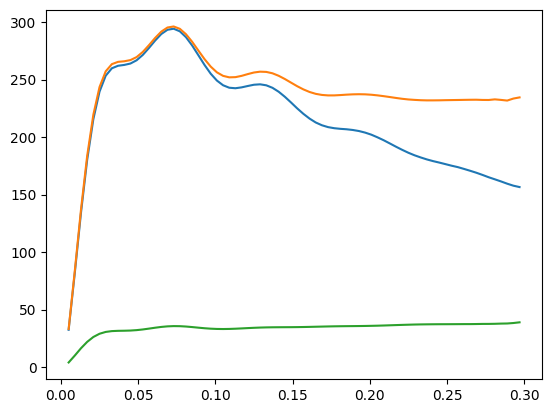

In [32]:
plt.plot(k, k*P0.get_Pl(θ, b, D))
plt.plot(k, k*P2.get_Pl(θ, b, D))
plt.plot(k, k*P4.get_Pl(θ, b, D))

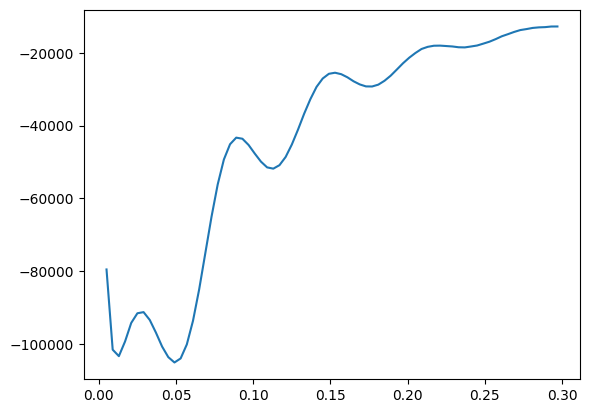

In [33]:
plt.plot(k, jacobian_P0[:,4])

In [34]:
# Generate multipoles using CLASS + PyBird (like in training data generation)
from classy import Class
from pybird.correlator import Correlator

z = cosmo_dict["z"]

# Setup CLASS parameters
cosmo_params = {
    "output": "mPk",
    "P_k_max_h/Mpc": 20.0,
    "z_pk": "0.0,3.",
    "h": cosmo_dict["H0"] / 100,
    "omega_b": cosmo_dict["ombh2"],
    "omega_cdm": cosmo_dict["omch2"],
    "ln10^{10}A_s": cosmo_dict["ln10As"],
    "n_s": cosmo_dict["ns"],
    "tau_reio": 0.0568,
    "N_ur": 2.033,
    "N_ncdm": 1,
    "m_ncdm": cosmo_dict["Mν"],
    "use_ppf": "yes",
    "w0_fld": cosmo_dict["w0"],
    "wa_fld": cosmo_dict["wa"],
    "fluid_equation_of_state": "CLP",
    "cs2_fld": 1.,
    "Omega_Lambda": 0.,
    "Omega_scf": 0.
}

# Initialize CLASS and compute linear power spectrum
M = Class()
M.set(cosmo_params)
M.compute()

# Generate k values and compute linear power spectrum
kk = 10 ** np.linspace(-5, 0, 200)
pk_lin = [M.pk_cb(k * M.h(), z) * M.h()**3 for k in kk]

# Get growth factors
D1 = M.scale_independent_growth_factor(z)
f1 = M.scale_independent_growth_factor_f(z)

# Initialize PyBird Correlator
N = Correlator()
dk = 0.004
kd = np.arange(0.005, 0.3, dk)

# Set correlator parameters
N.set({
    "output": "bPk",
    "multipole": 3,
    "kmax": 0.3,
    "xdata": kd,
    "km": 0.7,
    "kr": 0.35,
    "nd": 3e-4,
    "eft_basis": "eftoflss",
    "with_stoch": True,
    "with_bias": False,
    "with_resum": True
})

# Compute correlator
N.compute({
    "kk": kk,
    "pk_lin": pk_lin,
    "f": f1
})

# Get the multipole components (matching training data)
P11l = N.bird.P11l
Ploopl = N.bird.Ploopl
Pctl = N.bird.Pctl

print(f"CLASS+PyBird computation complete!")
print(f"P11l shape: {P11l.shape}")
print(f"Ploopl shape: {Ploopl.shape}")
print(f"Pctl shape: {Pctl.shape}")

CLASS+PyBird computation complete!
P11l shape: (3, 3, 74)
Ploopl shape: (3, 12, 74)
Pctl shape: (3, 6, 74)


In [35]:
# Compare emulator vs CLASS+PyBird
# Note: Need to apply bias contraction to get final multipoles from components

# For emulator: convert parameters to match expected format
θ_emu = np.array([
    cosmo_dict["z"],
    cosmo_dict["ln10As"],
    cosmo_dict["ns"],
    cosmo_dict["H0"],
    cosmo_dict["ombh2"],
    cosmo_dict["omch2"],
    cosmo_dict["Mν"],
    cosmo_dict["w0"],
    cosmo_dict["wa"]
])

# Compute with emulator
P0_emu = P0.get_Pl(θ_emu, b, D)
P2_emu = P2.get_Pl(θ_emu, b, D)
P4_emu = P4.get_Pl(θ_emu, b, D)

print(f"Emulator P0 shape: {P0_emu.shape}")
print(f"PyBird P11l shape (multipoles): {P11l.shape}")
print(f"\nNote: PyBird outputs components (P11, Ploop, Pct) that need bias contraction")
print(f"The emulator learns this full pipeline: CLASS → PyBird → bias contraction → multipoles")

Emulator P0 shape: (74,)
PyBird P11l shape (multipoles): (3, 3, 74)

Note: PyBird outputs components (P11, Ploop, Pct) that need bias contraction
The emulator learns this full pipeline: CLASS → PyBird → bias contraction → multipoles


In [36]:
# Apply bias contraction to PyBird components (as jaxeffort does internally)
b1, b2, b3, b4, b5, b6, b7, f = b[:8]  # Extract 8 bias parameters

# Create bias combinations (21 terms matching training)
biases = np.array([
    b1**2, 2*b1*f, f**2, 1., b1, b2, b3, b4,
    b1*b1, b1*b2, b1*b3, b1*b4,
    b2*b2, b2*b4, b4*b4,
    2*b1*b5, 2*b1*b6, 2*b1*b7,
    2*f*b5, 2*f*b6, 2*f*b7
])

# Extract and reshape components for each multipole (following trainer.jl logic)
# Stack P11 (3 terms), Ploop (12 terms), Pct (6 terms) = 21 total per k-bin
P0_stacked = np.hstack([P11l[0].T, Ploopl[0].T, Pctl[0].T])
P0_pybird = np.dot(P0_stacked, biases)  # ℓ=0

P2_stacked = np.hstack([P11l[1].T, Ploopl[1].T, Pctl[1].T])
P2_pybird = np.dot(P2_stacked, biases)  # ℓ=2

P4_stacked = np.hstack([P11l[2].T, Ploopl[2].T, Pctl[2].T])
P4_pybird = np.dot(P4_stacked, biases)  # ℓ=2

In [37]:
P11l = np.load(master_path+"P11l.npy")
Ploopl = np.load(master_path+"Ploopl.npy")
Pctl = np.load(master_path+"Pctl.npy")
Plin = np.load(master_path+"pk_lin.npy")

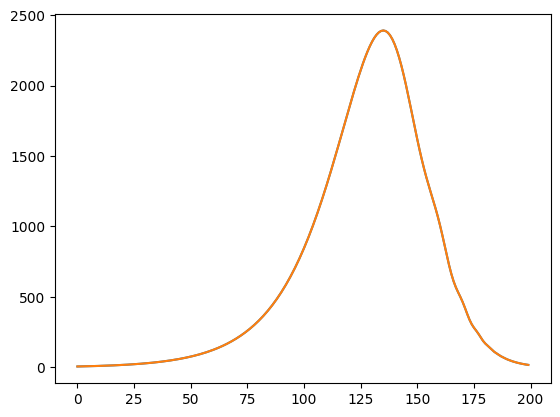

In [38]:
plt.plot(Plin)
plt.plot(pk_lin)

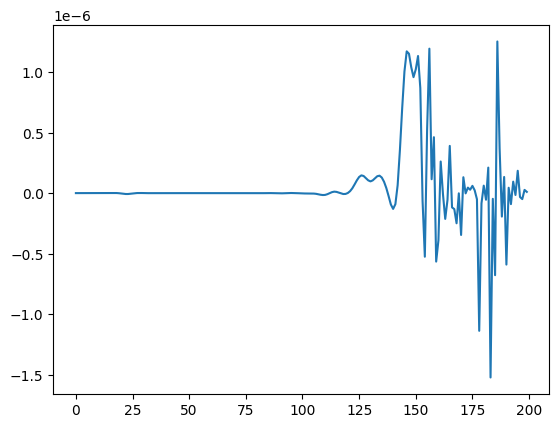

In [39]:
plt.plot(1-Plin/pk_lin)

In [40]:
P11l.shape

(3, 3, 74)

In [41]:
P0_stacked = np.hstack([P11l[0].T, Ploopl[0].T, Pctl[0].T])
P0_farm = np.dot(P0_stacked, biases)  # ℓ=0

P2_stacked = np.hstack([P11l[1].T, Ploopl[1].T, Pctl[1].T])
P2_farm = np.dot(P2_stacked, biases)  # ℓ=2

P4_stacked = np.hstack([P11l[2].T, Ploopl[2].T, Pctl[2].T])
P4_farm = np.dot(P4_stacked, biases)  # ℓ=2

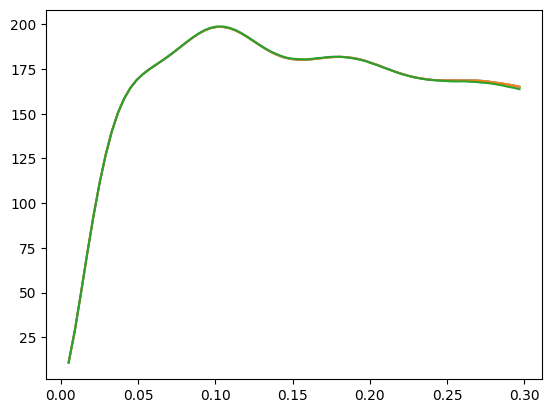

In [42]:
plt.plot(k,  k*P0_pybird)
plt.plot(k,  k*P0_farm)
plt.plot(k,  k*P0_emu)

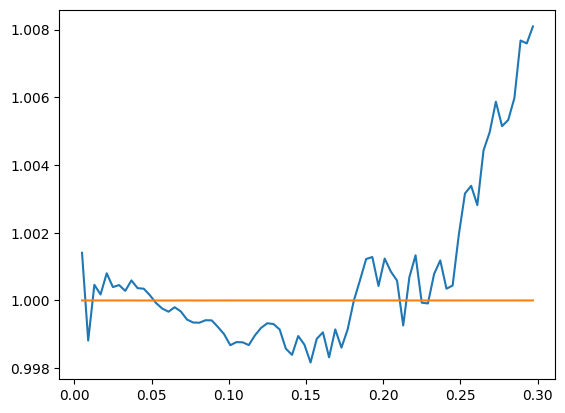

In [51]:
plt.plot(k,  P0_farm/P0_emu)
plt.plot(k,  P0_farm/P0_pybird)

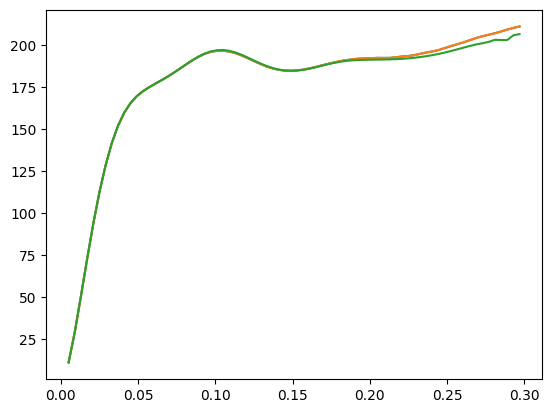

In [52]:
plt.plot(k,  k*P2_pybird)
plt.plot(k,  k*P2_farm)
plt.plot(k,  k*P2_emu)

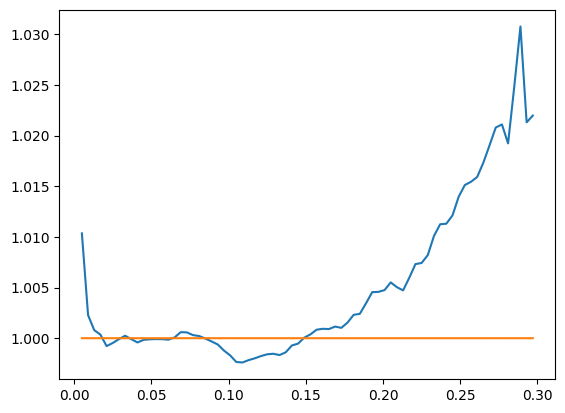

In [53]:
plt.plot(k,  P2_farm/P2_emu)
plt.plot(k,  P2_farm/P2_pybird)

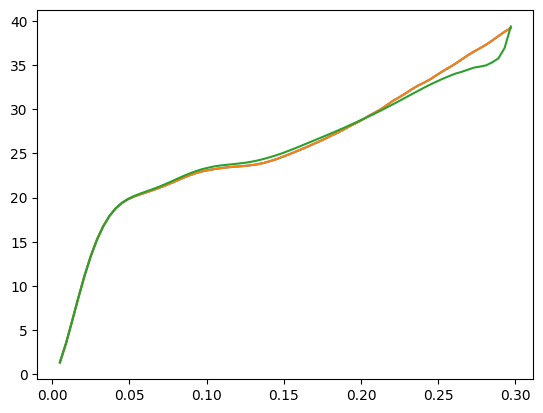

In [54]:
plt.plot(k,  k*P4_pybird)
plt.plot(k,  k*P4_farm)
plt.plot(k,  k*P4_emu)

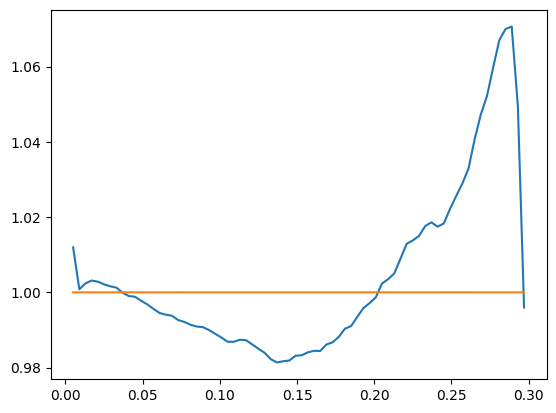

In [55]:
plt.plot(k,  P4_farm/P4_emu)
plt.plot(k,  P4_farm/P4_pybird)